In [1]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp
import pickle

Qrels = "qrels-clinical_trials.txt"

Queries = "topics-2014_2015-summary.topics"


with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title


eval = trec.TrecEvaluation(cases, Qrels)


pickle.dump(cases, open("cases.bin", "wb"))


In [2]:
import xml.etree.ElementTree as ET
import tarfile

tar = tarfile.open("clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
doc_ids = []
brief_titles = []
detailed_descriptions = []
brief_summaries = []
criterias = []
genders = []
minimum_ages = []
maximum_ages = []

namelist=tar.getnames()

for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        #print(txt)
        root = ET.fromstring(txt)

        judged = False
        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True
                doc_ids.append(doc_id.text.strip())
        if judged is False:
            continue
       
        brief_title = root.find('brief_title').text.strip()
        brief_titles.append(brief_title)
     
        try:
            detailed_description = root.find('detailed_description').text.strip()
            detailed_descriptions.append(detailed_description)
        except:
            detailed_descriptions.append(brief_title)

        try:
            brief_summary = root.find('brief_summary').text.strip()
            brief_summaries.append(brief_summary)
        except:
            brief_summaries.append(brief_title)
        
        try:
            criteria = root.find('criteria').text.strip
            criterias.append(criteria)
        except:
            criterias.append(brief_title)

"""
        for gender in root.iter('gender'):
            #print(gender)
            genders.append(gender.text.strip())
          

        for minimum_age in root.iter('minimum_age'):
            #print(minimum_age)
            minimum_ages.append(minimum_age.text.strip())
        

        for maximum_age in root.iter('maximum_age'):
            #print(maximum_age)
            maximum_ages.append(maximum_age.text.strip())
"""
tar.close()

print(len(doc_ids))
print(len(brief_titles))
print(len(detailed_descriptions))
print(len(brief_summaries))
print(len(criterias))
print(len(genders))
print(len(minimum_ages))
print(len(maximum_ages))

# Aqui criamos os docs pickle para cada uma das partes dos documentos
pickle.dump(doc_ids, open("doc_ids.bin", "wb"))
pickle.dump(brief_titles, open("brief_title.bin", "wb"))
pickle.dump(detailed_descriptions, open("detailed_description.bin", "wb"))
pickle.dump(brief_summaries, open("brief_summary.bin", "wb"))
pickle.dump(criterias, open("criteria.bin", "wb"))
pickle.dump(genders, open("gender.bin", "wb"))
pickle.dump(minimum_ages, open("minimum_age.bin", "wb"))
pickle.dump(maximum_ages, open("maximum_age.bin", "wb"))


3626
3626
3626
3626
3626
0
0
0


Classe RetrievalModel: definimos a classe abstrata


In [3]:
import abc  # é preciso importar isto quando queremos definir uma classe abstrata

class RetrievalModel:  # vamos criar uma classe abstrata que é o molde para todas as nossas classes, cada uma um modelo
    @abc.abstractmethod  # para sabermos que RetrievalModel é uma classe abstrata e que, portanto, não pode ser instanciada, ie, "concretizada"
    def search(self):  # aqui nomeia-se uma das funcoes desta classe, neste caso, aquela onde vamos por o codigo q ordenava os docs e ainda classificava a performance do nosso modelo (junto para nao termos q mudar tanto o codigo)
        pass  # nao se pode por nada aqui na abstrata, apenas em cada classe "filho" é que se define a função, aqui apenas se nomeia


VSM Unigram


In [4]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

class VSM(RetrievalModel):  # definimos a classe de um dos modelos e pomos o RetrievalModel para dizer q esta classe é uma subclasse da classe abstrata
    def search(self, caseid, docs):  # aqui definimos a funcao que faz tudo o q o nosso modelo fazia, pus o codigo ca dentro, pus self.doc em vez de docs
        index = TfidfVectorizer(ngram_range=(
            1, 1), analyzer='word', stop_words=None)
        index.fit(docs)
        X = index.transform(docs)
        query = cases[caseid]
        query_tfidf = index.transform([query])
        doc_scores = 1-pairwise_distances(X, query_tfidf, metric='cosine')
        scores = doc_scores.tolist()
        return scores


LMJM Unigram


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from collections import Counter

class LMJM(RetrievalModel):
    def search(self, caseid, docs):
        index = CountVectorizer(ngram_range=(1, 1), analyzer='word')
        X = index.fit(docs)
        corpus_cv = index.transform(docs)
        all_scores = []
        lmbd = 1
        prob_word_docs = corpus_cv/np.sum(corpus_cv, axis=1)  # p(t|md)
        prob_word_corpus = np.sum(corpus_cv, axis=0) / \
            np.sum(corpus_cv)  # p(t|mc)
        log_mixture = np.log(lmbd*prob_word_docs + (1-lmbd)*prob_word_corpus)
        query = cases[caseid]
        query_cv = index.transform([query])
        total = log_mixture*query_cv.T
        return total


Chamar as classes para obtermos os valores


In [6]:
import pickle
import trec
import numpy as np

# Aqui abrimos cada documento pickle e damos-lhes os nomes para usar nas funcoes seguintes
ids = pickle.load(open("doc_ids.bin", "rb"))
brief_title = pickle.load(open("brief_title.bin", "rb"))
detailed_description = pickle.load(open("detailed_description.bin", "rb"))
brief_summary = pickle.load(open("brief_summary.bin", "rb"))
criteria = pickle.load(open("criteria.bin", "rb"))
gender = pickle.load(open("gender.bin", "rb"))
minimum_age = pickle.load(open("minimum_age.bin", "rb"))
maximum_age = pickle.load(open("maximum_age.bin", "rb"))
cases = pickle.load(open("cases.bin", "rb"))


In [7]:
#definir modelos e campos
models = [VSM()]
#, LMJM()
fields = [brief_title, detailed_description, brief_summary, criteria]

In [8]:
# separate training and test queries
print(len(cases))
cases_training = []
cases_test = []
i = 0
k = 12
for caseid in cases:
    if i <= 11:
        cases_test.append(caseid)
    else:
        cases_training.append(caseid)
    i += 1
print(len(cases_training))
print(len(cases_test))

60
48
12


In [9]:
# buscar listas
queries_training = []
docs_training = []
VSM_bt_training = []
VSM_dd_training = []
VSM_bs_training = []
VSM_cr_training = []
LMJM_bt_training = []
LMJM_dd_training = []
LMJM_bs_training = []
LMJM_cr_training = []
y_training = []

for caseid in cases_training:
    case_rel = []
    field_ind = 0
    aux = eval.relevance_judgments.loc[eval.relevance_judgments['query_id'] == int(
        caseid)]
    docs = aux['docid'].tolist()
    relevances = aux['rel'].tolist()
    for rel in relevances:
        if rel == 0:
            y_training.append(rel)
        elif rel == 1 or rel == 2:
            y_training.append(1)
    for docid in docs:
        case_rel.append(ids.index(docid))
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for rel in case_rel:
                value=scores[rel]
                if field_ind == 0:
                    queries_training.append(caseid)
                    docs_training.append(rel)
                    VSM_bt_training.append(value[0])
                elif field_ind == 1:
                    VSM_dd_training.append(value[0])
                elif field_ind == 2:
                    VSM_bs_training.append(value[0])
                elif field_ind == 3:
                    VSM_cr_training.append(value[0])
                elif field_ind == 4:
                    LMJM_bt_training.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_training.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_training.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_training.append(value[0])
            field_ind += 1
print(len(VSM_bt_training))
print(len(VSM_dd_training))
print(len(VSM_bs_training))
print(len(VSM_cr_training))
print(len(y_training))


print(VSM_bt_training)


2920
2920
2920
2920
2920
[0.2823721230207641, 0.011587366741948713, 0.02215745199026764, 0.00845953044711989, 0.0, 0.0, 0.0, 0.012761348005371098, 0.011741359488619874, 0.0, 0.008600404363001468, 0.011242226653693677, 0.0074011332285481846, 0.005151787948621145, 0.00967039357265842, 0.07318063132163832, 0.013850048321261688, 0.0, 0.0, 0.011298800738760661, 0.0, 0.0, 0.06010386315834815, 0.0, 0.01079731081210078, 0.0, 0.005244857990786667, 0.004164905291878962, 0.04549158727755276, 0.005221846293158694, 0.013258368834407674, 0.0035847287355786905, 0.0, 0.022661725354858442, 0.14481214078832827, 0.0032541082435021407, 0.01158194074764829, 0.155611528727418, 0.01918841185287623, 0.0038027575284008686, 0.01590925571093804, 0.0, 0.00466291473665259, 0.0, 0.014832920794615068, 0.023099478582769617, 0.007293513394465934, 0.0046100254757821535, 0.0, 0.010591433514872461, 0.0, 0.011616926133792727, 0.0, 0.005565183657496475, 0.0, 0.005309548550720522, 0.0, 0.01253549731267145, 0.004442936866631

     query   doc    VSM_bt    VSM_dd  VSM_bs    VSM_cr  Y
0   201413   171  0.282372  0.323833     0.0  0.282372  0
1   201413   301  0.011587  0.000000     0.0  0.011587  1
2   201413   491  0.022157  0.000000     0.0  0.022157  1
3   201413   516  0.008460  0.000000     0.0  0.008460  0
4   201413   522  0.000000  0.000000     0.0  0.000000  0
..     ...   ...       ...       ...     ...       ... ..
95  201414  2308  0.024632  0.000000     0.0  0.024632  0
96  201414  2434  0.029518  0.000000     0.0  0.029518  0
97  201414  2474  0.092779  0.000000     0.0  0.092779  0
98  201414  2512  0.024745  0.062980     0.0  0.024745  0
99  201414  2551  0.023582  0.063290     0.0  0.023582  0

[100 rows x 7 columns]


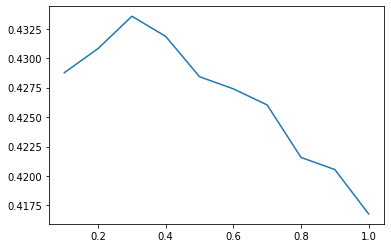

In [10]:
# Calcular coeficientes da logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

candidates = {'query': queries_training,
              'doc': docs_training,
              'VSM_bt': VSM_bt_training,
              'VSM_dd': VSM_dd_training,
              'VSM_bs': VSM_bs_training,
              'VSM_cr': VSM_cr_training,
              'Y': y_training
              }
df = pd.DataFrame(candidates, columns=['query', 'doc',
                                       'VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr', 'Y'])

print(df.head(100))

x = df[['VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr']]
y = df['Y']

# cross-validation for different values of C
c_values = [ 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] 
c_ap = []
c_p10 = []
k = 5
kf = KFold(n_splits=k, random_state=None)

for c in c_values:
    acc_score = []
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index, :], x.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(random_state=0, C=c, class_weight='balanced').fit(X_train, y_train)
        pred_values = clf.predict(X_test)
        acc = accuracy_score(pred_values, y_test)
        acc_score.append(acc)
    avg_acc_score = sum(acc_score)/k
    c_ap.append(avg_acc_score)

plt.plot(c_values, c_ap)


In [11]:
clf = LogisticRegression(
    random_state=0, C=3, class_weight='balanced').fit(x, y)
coefs = clf.coef_[0]
print('Coefs: {}'.format(coefs))


Coefs: [-0.33623517 -1.60532446 -0.29509851 -0.33623517]


In [12]:
#scores para as queries de teste
p10_list=[]
recall_list=[]
ap_list=[]
ndcg5_list=[]
mrr_list=[]

avg_precision_11point = np.zeros(11)

for caseid in cases_test:
    VSM_bt_test = []
    VSM_dd_test = []
    VSM_bs_test = []
    VSM_cr_test = []
    """
    LMJM_bt_test = []
    LMJM_dd_test = []
    LMJM_bs_test = []
    LMJM_cr_test = []
    """
    field_ind = 0
    zs = []
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for id in range(0, len(ids)):
                value=scores[id]
                if field_ind == 0:
                    VSM_bt_test.append(value[0])
                elif field_ind == 1:
                    VSM_dd_test.append(value[0])
                elif field_ind == 2:
                    VSM_bs_test.append(value[0])
                elif field_ind == 3:
                    VSM_cr_test.append(value[0])
                """
                elif field_ind == 4:
                    LMJM_bt_test.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_test.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_test.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_test.append(value[0])
                """
            field_ind += 1
    """     
    print(len(VSM_bt_test))
    print(len(VSM_dd_test))
    print(len(VSM_bs_test))
    print(len(VSM_cr_test))
    """   
    for line in range(0, len(VSM_bt_test)):
        z = coefs[0]*VSM_bt_test[line]+coefs[1]*VSM_dd_test[line] + coefs[2]*VSM_bs_test[line]+coefs[3]*VSM_cr_test[line]
        zs.append(z)
    
    cand={'_id': ids, 'score': zs}
    results = pd.DataFrame(cand, columns = ['_id', 'score'])
    results.sort_values(by=['score'], inplace=True, ascending=True)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results, caseid)
    [precision_11point, recall_11point,
        total_relv_ret] = eval.evalPR(results, caseid)

    p10_list += [p10]
    recall_list += [recall]
    ap_list += [ap]
    ndcg5_list += [ndcg5]
    mrr_list += [mrr]


    #print(df.head(10))
    #print("--------------------------------------------------------------------------------")
print(np.mean(p10_list))
print(np.mean(recall_list))
print(np.mean(ap_list))
print(np.mean(ndcg5_list))
print(np.mean(mrr_list))

0.049999999999999996
1.0
0.03900866216620967
0.057648598640472316
0.005791505791505791
